In [116]:
import pandas as pd
import code_base as cb
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm


# **Group Project - Earnings Adjusted Momentum & Value**

**Group-21** <br>
Member: LAM Chun Ming <br>
EID: 58555905 <br>


## **1 Introduction** 
- there has been a literature of work that suggest the combination of momentum and value produce a better result than combined
- furthermore there has also been a wide literature of Earning Announcement effect where abnormal returns have been found from earning announcemnts
- Like to investigate whether there whether announcement effects goes beyond the anoncement period, and affect stocks on a monthly basis 

### **1.1 Momentum & Value**


### **1.2 Earning Announcement Premium**
- we see the effect of value and momentum factors having postitive effects when combined together
- on their is also wide documentation of "earning announcement effect", where abnormal returns have been found from earning announcements from holding before and after announcement periods 

- this is from,
- rather than the indiviudal day holding we would like to investimage if this would also affect the a stock's factor exposure, 
- we would like to investigate if this would substaintially affect the 

## **2 Data** 

### **2.1 Collection Method**

we have collected 21 years of monthly data from 2000 to 2021 from a Bloomberg Terminal, which was used to generate a 20 years backtest period between 2001 and 2001. The first year was not usable as the momentum factor requires a 12 month lookback period. 

specifically, we collected the adjusted closing price, market cap, announcement earnings, announcement earnings estimate, price to book ratio, and S\&P 500 membership information data totaling 264 sample periods and 1134 stock tickers, which where all stock tickers that were members of the S\&P 500 at any point within this period.

Membership information is sampled at the end of the year, whilst stock data is sampled at the start of the month. Lastly any announcement information is sampled at the time of announcement, then atrributed to the month at which it occured (for example, announcement in 2003-05-23 -> 2003-05)

### **2.2 Data Formatting**
using the data collected we then created Momentum (MOM), Value (VAL), Earning Suprise (SUP) fields

In [117]:
# importing the collected data
df_dict = cb.read_multi_csv(
    filenames=["df_memboolG_spx","df_mcap_spx","df_monthly_spx","df_annsup_spx","df_annest_spx","df_anndat_spx","df_annacc_spx","df_P2BR_spx","df_Beta_spx"],
    name = ["tmbool", "mcap", "price", "annsup", "annest", "anndat", "annacc", "ptbr", "beta"]
)
df_dict["tmbool"].shape

(264, 1134)

#### **Factor Constructution: Value (VAL)**
The value facotr "**VAL**" is the inverse of the price to book ratio, to which we applied mean, stardard deviation normaisation from the crossectional mean and standard devations at time $t$

$$ \text{V}_{t,i} = \frac{1}{\text{PTBR}_{t,i}}$$
$$ \text{VAL}_{t,i} = \frac{V_{t,i} - \mu_t }{\sigma_t}$$

In [118]:
# value factor, normalisation applied later
df_dict["VAL"] = 1/df_dict["ptbr"]

#### **Factor Constructution: Momentum (MOM)**
We created this first from calculating the monthly returns, due to our notation this is the returns for holding stock ticker $[i]$ from period $[t-1] \to [t]$ 

$$ R_{t,i} = \frac{P_{t,i} - P_{t-1,i}}{P_{t-1,i}}$$

The momentum factor "**MOM**" is then the cumulative returns of the past year, excluding the most recent month, we then applied a mean std normalisation (again applied later)

$$M_{t,i} = \prod_{k=1}^{12}{(1+R_{t-k,i})}$$
$$ \text{MOM}_{t,i} = \frac{M_{t,i} - \mu_t }{\sigma_t}$$

In [119]:
# creating stock returns 
df_dict["ret"] = (df_dict["price"]/df_dict["price"].shift(1))-1

# calculating momentum factor, the returns from -2 to -12
tdf = pd.DataFrame(df_dict["ret"])
tdf +=1 
tdf = tdf.rolling(11,11).apply(np.prod, raw=True)
tdf = tdf**(1/11)

df_dict["MOM"] = tdf.shift(1)
df_dict["MOM"] -=1

df_dict["avgret"] = tdf.rolling(12,12).apply(np.mean, raw=True)
df_dict["ABR"] = tdf.div(df_dict["avgret"])

# # absolute momentum (where we take mean of 0 when calculating, )
df_dict["MOM-A"] = df_dict["MOM"].copy()
# # df_dict["MOM-A"] = df_dict["MOM-A"].divide(df_dict["MOM-A"].std(1,skipna=True), "index")

#### **Factor Constructution: Earnings Suprise & Other Earings Data (SUP, ERG, ETG)**
We delayed (shifted) actual Earnings results by 1 period to prevent any hindsight bais (for example earnings announcenced : 2003-05-23 => data collected: 2003-05, => data avaible: 2003-06). We did not delay the earnings estimate as we assume resonable estimate are likely avaliable by the start of the month

The suprise factor is directed collected from Bloomberg and delayed by 1 period, mathematically this is simply the difference between actual earnings and earnings estimate. for factir "**SUP-Z**" we then applied the mean std normalisation, whilst for factor "**SUP**" we did not 

we then also created supplimentary factors like earnings growth "**ERG**" and earnings estimate growth "**ETG**", which are the % growht from 4 earnings announcements ago. We chose 4 earnings announcements as earnings are typically quarterly, and can also be seasonal; this choice allows us to focus on relative growth on annual basis, to which we applied a std normalisation

$$E_{t,i} = \frac{E_{t,i}-E_{i}^{[4]}}{E_{i}^{[4]}}$$

$$\text{ERG}_i \text{/}\text{ETG}_i = \frac{E_{t,i}}{\sigma_t} $$





In [120]:

# shifting regieme by 1 to prevent hindsight bias  
df_dict["annacc"]=df_dict["annacc"].shift(1)
df_dict["annsup"]=df_dict["annsup"].shift(1)

# creating a earnings suprise factor (SUP/ SUP-Z)
df_dict["SUP"] =  df_dict["anndat"].shift(1)*df_dict["annsup"]

# earnings growth factor (ERG)
df_dict["AP4"] = cb.past_nvalid_values(df_dict["annacc"],4)
ans = (df_dict["annacc"].divide(df_dict["AP4"])-1)
ans[ans<-100]=-100
ans[ans>2000]=2000
df_dict["ERG"] = ans
df_dict["ERG"].ffill(inplace=True)

# earning estimates (EST), actual earnings (ERN)
df_dict["EST"] = df_dict["annest"]

df_dict["EP4"] = cb.past_nvalid_values(df_dict["annest"],4)
ans = (df_dict["annest"].ffill().divide(df_dict["EP4"])-1)
ans[ans<-100]=-100
ans[ans>2000]=2000
df_dict["ETG"] = ans
df_dict["ETG"].ffill(inplace=True)

In [121]:


# size factor
df_dict["CAP"] = df_dict["mcap"]

out_dict = cb.dict_transfer(df_dict,["ret","VAL","MOM","MOM-A","SUP","ERG","CAP","EST","ETG","ABR"])

#### **In Sample & Out of Sample Sets**
we split the collected data into a In Sample (60% from 2001 -> 2013) and Reserved Out of Sample Data Set (40% from 2013-> 2021) to reduced bias and data mining risks

In [122]:
# generate a "test" set & "training" set
tmbool =  df_dict["tmbool"].copy()
# ratio = 60%
ratio = 0.6
row = int(round((tmbool.shape[0])*ratio,0))
tmbool_train = tmbool.iloc[12:row,:]
tmbool_test = tmbool.iloc[row:,:]

#### **Normalisation**

we then applied mean standard deviation normalisation to Momentum Factor and Value Factor to cacluat standard scores.

we also applied just standard deviation normalistion to our supplimentary factors (ERG and ETG) to preserve the positive and negative directional information

values above 5 ("standard deviations") are  discarded by setting them to 0, as they likely represent extereme cases data points less suitable to high level statistical analysis



In [123]:


# df_dict["ERG"] = df_dict["ERG"].divide(df_dict["ERG"].std(1,skipna=True), "index")
# apply normalisation

# out_dict = cb.dict_transfer(df_dict,["ret","VAL","MOM","MOM-A","SUP","ERG","CAP","EST","ETG","ARG","DIF","ABR"])


data = cb.data_obj(tmbool,out_dict)

data.calc_z_scores(True,["MOM","VAL"],clip="Discard")
data.calc_z_scores(True,["MOM-A","ERG","ETG","ABR"],False,clip="Discard")



## **3 Emperical Analysis**
### **3.1 Portfolio Construction and Momentum and Value Benchmark**
We first investigate the effect of the value and momentum factor portfolio, which is used as our benchmark.

we constructing a composite score by taking the simple average of our momentum and value standard score. 

$$S_{i,t} = 0.5 * \text{MOM}_{i,t} + 0.5*\text{VAL}_{i,t}$$

we construct the portfolio by ranking all scores and holding a long position in the top 30% of all stocks, whilst shorting the bottom 30%, for each stock selected they hold equal weighting and both long and short portfolio net to 0 for a dollar neutrality overall

as our returns are constructed as the returns holding stock $[i]$ from period $[t-1]->[t]$, we shift our portfolio weights one period forward to represent returns from $[t]->[t+1]$. at each month the portfolio is rebalanced in accordance with our score. We apply a 10 basis point simple transaction fee, calculated as the difference between the portfolio weights in each period.




In [124]:
# calculate momentum value composite factor  
momval = (0.5*data.get("VAL").fillna(0)
          +0.5*data.get("MOM").fillna(0))
data.append("MOM_VAL", momval)
# data.regulate(["MOM_VAL"])
# data.calc_z_scores(inplace=True,fields=["MOM_VAL"])
port_momval = data.to_port("MOM_VAL",tmbool=tmbool_train)


port_momval.gen_weights_from_score(0.3)
momval_ret, momval_cret = port_momval.get_port_ret(weight=port_momval.lsw,bps=10)



To evalue the result of our momentum & value portfolio, we also apply the same method to our momentum and value factors by themselves, we then plotted the cumulative  long short portfolio factor returns, net of transaction fees below

Text(0.5, 1.0, 'Factor Portfolio Comparison')

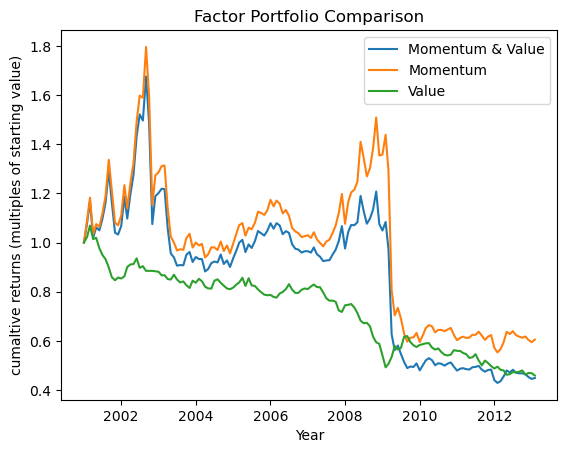

In [125]:
port_mom = data.to_port("MOM",tmbool=tmbool_train)
port_mom.gen_weights_from_score(0.3)
mom_ret, mom_cret = port_mom.get_port_ret(weight=port_mom.lsw,bps=10)

port_val = data.to_port("VAL",tmbool=tmbool_train)
port_val.gen_weights_from_score(0.3)
val_ret, val_cret = port_val.get_port_ret(weight=port_val.lsw,bps=10)

comb_ret = (val_ret+mom_ret)/2
comb_cret=(comb_ret+1).cumprod()
# ploting graph
plt.plot(momval_cret)
plt.plot(mom_cret)
plt.plot(val_cret)

plt.legend(["Momentum & Value","Momentum","Value"])
plt.xlabel("Year")
plt.ylabel("cumaltive returns (multiples of starting value)")
plt.title("Factor Portfolio Comparison")



In [126]:
# Information Ratios
print("Information Ratios")
print("Combined Relative to Momentum : {}".format(round(cb.infomation_ratio(momval_ret,mom_ret),3)))
print("Combined Relative to Value : {}".format(round(cb.infomation_ratio(momval_ret,val_ret),3)))

Information Ratios
Combined Relative to Momentum : -0.269
Combined Relative to Value : 0.022


we actuall find that all factors portfolios underperformned the S&P 500 index, but also that the value and momentum combined portfilo also underperformend momentum factor by itself. this is in contrary to the findings in Asness 2013. never-the-less, we shall use this as our benchmark, due to our stated research interest 

#### **Investigating the result: Different Long Short Portfolios**

Text(0.5, 1.0, 'Quantile Portfolio Comparison')

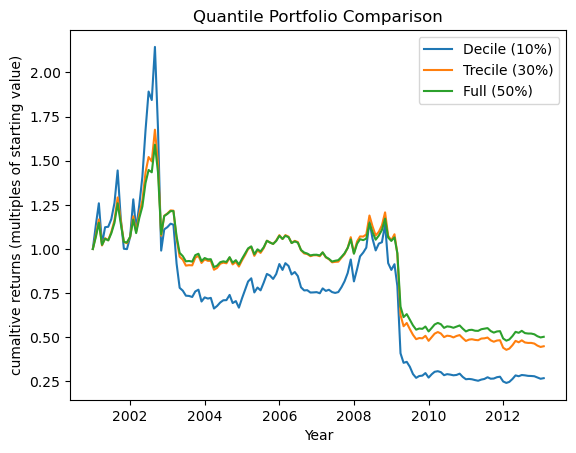

In [127]:
# Decile Portfolios (10%)
port_momval.gen_weights_from_score(0.1)
momval_tret, momval_tcret = port_momval.get_port_ret(weight=port_momval.lsw,bps=10)

# Trecile Portfolios (30%), standard in Fama French
port_momval.gen_weights_from_score(0.3)
momval_tret2, momval_tcret2 = port_momval.get_port_ret(weight=port_momval.lsw,bps=10)

# Full Portfolios (50%), holding the entire universe
port_momval.gen_weights_from_score(0.5)
momval_tret3, momval_tcret3 = port_momval.get_port_ret(weight=port_momval.lsw,bps=10)

plt.plot(momval_tcret)
plt.plot(momval_tcret2)
plt.plot(momval_tcret3)

plt.legend(["Decile (10%)","Trecile (30%)","Full (50%)"])
plt.xlabel("Year")
plt.ylabel("cumaltive returns (multiples of starting value)")
plt.title("Quantile Portfolio Comparison")


In [128]:
# Information Ratios
print("Information Ratios Relative to Decile (10%) Portfolio")
print("Trecile (30%) Portfolio : {}".format(round(cb.infomation_ratio(momval_tret2,momval_tret),3)))
print("Full (50%) Portfolio : {}".format(round(cb.infomation_ratio(momval_tret3,momval_tret),3)))


Information Ratios Relative to Decile (10%) Portfolio
Trecile (30%) Portfolio : 0.024
Full (50%) Portfolio : 0.027


we see that the trecile portfolio actually captures the majority of the benefits. A full portfolio only offers marginal improvements, whilst the decile porftolios actually risk overconcentration and noise. 

We conclude here that the bad performance was **not** due to our choice of this value

#### **Investigating the result: Long vs Short Portfolios**
next we investigate further into the impact between the long and short portfolio. Again we did not see an ourperformance from our momentum and value factors; however we do see that the factor performance is much stronger on the long side

Text(0.5, 1.0, 'Factor Long Portfolio Comparison')

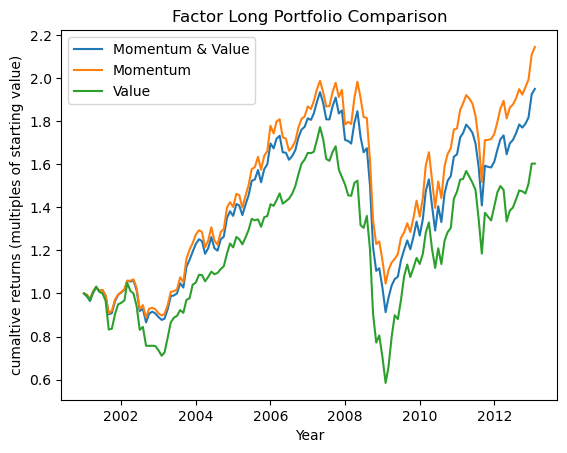

In [129]:

momval_tret, momval_tcret = port_momval.get_port_ret(weight=port_momval.lw,bps=10)
mom_tret, mom_tcret = port_mom.get_port_ret(weight=port_mom.lw,bps=10)
val_tret, val_tcret = port_val.get_port_ret(weight=port_val.lw,bps=10)


plt.plot(momval_tcret)
plt.plot(mom_tcret)
plt.plot(val_tcret)


plt.legend(["Momentum & Value","Momentum","Value"])
plt.xlabel("Year")
plt.ylabel("cumaltive returns (multiples of starting value)")
plt.title("Factor Long Portfolio Comparison")



Text(0.5, 1.0, 'Factor Short Portfolio Comparison')

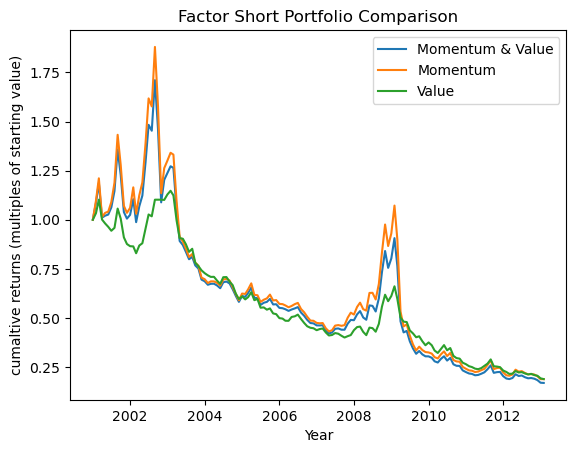

In [130]:
_, momval_tcret = port_momval.get_port_ret(weight=port_momval.sw,bps=10)
_, mom_tcret = port_mom.get_port_ret(weight=port_mom.sw,bps=10)
_, val_tcret = port_val.get_port_ret(weight=port_val.sw,bps=10)

plt.plot(momval_tcret)
plt.plot(mom_tcret)
plt.plot(val_tcret)

plt.legend(["Momentum & Value","Momentum","Value"])
plt.xlabel("Year")
plt.ylabel("cumaltive returns (multiples of starting value)")
plt.title("Factor Short Portfolio Comparison")


wilst again there has been no outperformance from the value momentum portfolio. futhermore we can also observe that the short portfolios for all factors have been suffering from losses equal or greater than their long portfolios; and in time of crisis and short portfolio was not sufficent to cover for losses from the long portfolios. 

**this suggest perhaps uniquely from this data set:**

- **From the momentum effects:** this suggest that most stocks in the market have been going up at similar rates regadless of past returns (pointing to a high level of market efficency during normal periods), whilst in drawdown events the fastest growing stocks are also drawing down much quicker than low returning stocks 

- **From the value effects:** cheap stocks have consistently underperformed in this universe (this might be the case, as it is a managed large cap index where relatively cheap stocks in the index is not truely "cheap")

- **Most Interestingly:** as can be seen from the figure below, it is the most expensive stocks that have outperformed, both the recently highest returning stocks, as well as the cheapest stocks. 

Text(0.5, 1.0, 'Factor Portfolio Comparison')

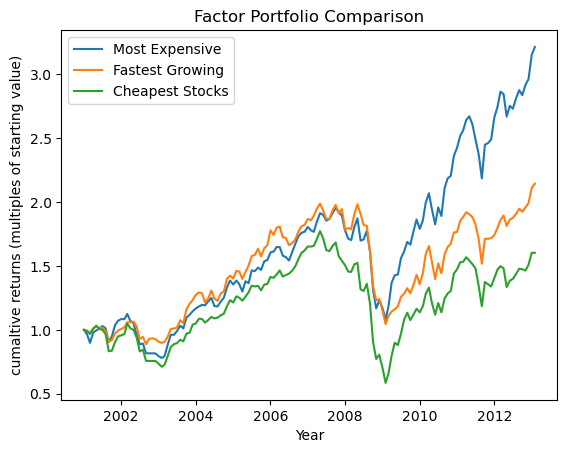

In [ ]:
# ploting graph
_, val_tcret = port_val.get_port_ret(weight=-port_val.sw,bps=10)
_, mom_tcret = port_val.get_port_ret(weight=port_mom.lw,bps=10)
_, val2_tcret = port_val.get_port_ret(weight=port_val.lw,bps=10)

plt.plot(val_tcret)
plt.plot(mom_tcret)
plt.plot(val2_tcret)

plt.legend(["Most Expensive","Fastest Growing","Cheapest Stocks"])
plt.xlabel("Year")
plt.ylabel("cumaltive returns (multiples of starting value)")
plt.title("Factor Portfolio Comparison")

### **3.2 Earnings Factors, and Simple Combined Score**
To try to incorporate the idosyncratic effects from earnings and investigate how they affect momentum and value on a monthly freqency, we first investigate taking a simple approach from our earnings growth, earnings estimate , and suprise factors

(Note in doing so we are implicitly disagreeing with the market effiency hypothesis, where excess returns are only given to the undertaking of risk)


To do so we follow a 3 step plan
1) construct single factor portfolios, **inspect for for negatively correlated Factor Returns** (this comes from our understanding, that the negative correlation can compliment portfolio returns)
2) **consider if fundmental resoning behing the negative correlation exists** (for example, Earnings Suprise can serve as addtional inputs to whether a momentum trend continues, whilst and Earnings Growth and Earnings Estimates Grwoth can not only do the former but provide informatin on a value stock's future price)
3) **construct a combined score portfolio** as before


#### **Constructing Simple Factor Portfolios**

Text(0.5, 1.0, 'Factor Portfolio Comparison')

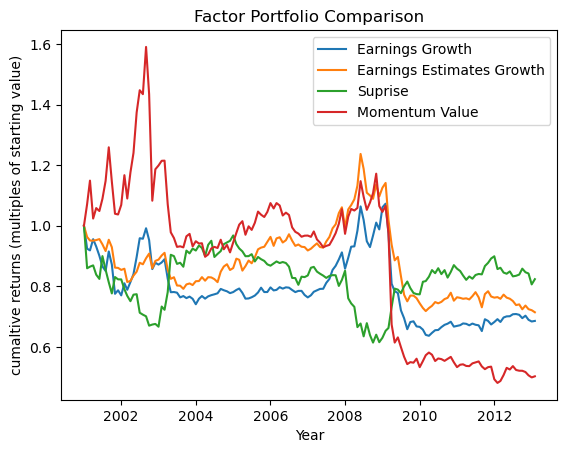

In [165]:
# Earnings Growth Portfolio
port_erg = data.to_port("ERG",tmbool=tmbool_train)
port_erg.gen_weights_from_score(0.3)
_, erg_cret = port_erg.get_port_ret(weight=port_erg.lsw,bps=10)
plt.plot(erg_cret)

# Earnings Estimates Portfolio
port_etg = data.to_port("ETG",tmbool=tmbool_train)
port_etg.gen_weights_from_score(0.3)
_, etg_cret = port_etg.get_port_ret(weight=port_etg.lsw,bps=10)
plt.plot(etg_cret)

# Earnings Suprise Portfolio
port_sup = data.to_port("SUP",tmbool=tmbool_train)
port_sup.gen_weights_from_score(0.3)
_, sup_cret = port_sup.get_port_ret(weight=-port_sup.lsw,bps=10)
plt.plot(sup_cret)

plt.plot(momval_cret)

plt.legend(["Earnings Growth","Earnings Estimates Growth","Suprise", "Momentum Value"])
plt.xlabel("Year")
plt.ylabel("cumaltive returns (multiples of starting value)")
plt.title("Factor Portfolio Comparison")

#### **Factors Selection & Creation**

Here we see that Earnings estimates growth have much more "information" than Earings Growth itself as visible by the out-performance. Furthermore Whilst Earning Suprise provide some information, this is not reflected in it factor portfolio returns making it's inclusion undesireable.

Thefore it making the Earnings Estimates growth more desireable factor out of our choice. **However**, whlist there is some resoning of why **our choice of Earnings Estimates Growth (ETG)** might support negatively correlated factor returns, as addtional data points, the resoning behind which is **somewhat weak**; therefore expecting it be less likely to hold in the out of sample period

finally to create the factor, we adjusted the weighting as we have found that an equal weight did not lead to any meaningful impact, therefore leading to an increased weighting of 10%, 10% & 80%



0.06981517086218178

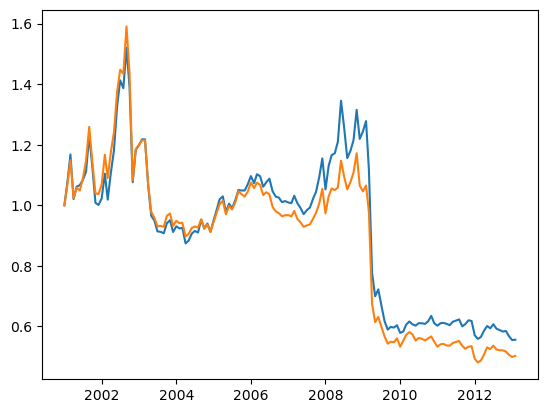

In [ ]:
# calculate momentum value composite factor  
composite = (+0.1*data.get("VAL").fillna(0)
             +0.1*data.get("MOM").fillna(0)
             +0.8*data.get("ETG").fillna(0))
data.append("COM", composite)

data.calc_z_scores(inplace=True,fields=["COM"])
port_com = data.to_port("COM",tmbool=tmbool_train)
port_com.gen_weights_from_score(0.3)

com_ret, com_cret = port_com.get_port_ret(weight=port_com.lsw,bps=10)

momval_ret, momval_cret = port_momval.get_port_ret(weight=port_momval.lsw,bps=10)


plt.plot(com_cret)
plt.plot(momval_cret)

cb.infomation_ratio(com_ret,momval_ret)


From our methodology, we observed a marginal singal improvement from the introduction of our "Earnings Estimate Growth Factor "

### Method 1) Spliting Weights

0.19759827546767042

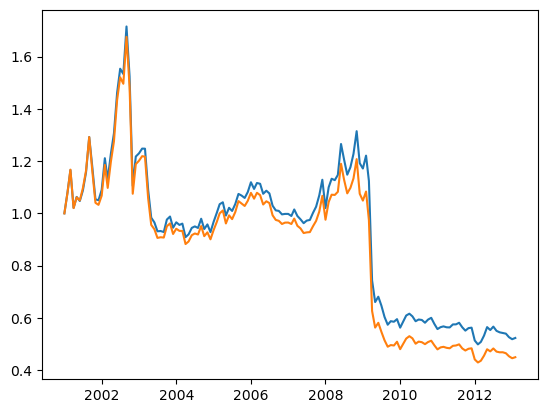

In [181]:
try: 
    data.data_dict.pop("EJC")
except:
    pass 

sup = data.get("SUP")
mom = data.get("MOM")
val = data.get("VAL")

mom.fillna(0,inplace = True)
val.fillna(0,inplace = True)
cuttoff = 0.6

fmb = 0.6
fvb = 0.4
fcb = 0.1

fmp = 0.75
fvp = 0.25
fcp = 1

# fmn = -1
# fvn = -0.5
# fcn = -0.25

fmn = 0.825
fvn = 0.125
fcn = -1.75

# basecase 

ejustc = fmb*mom + fvb*val + fcb

# positive
ejustc[sup>=cuttoff] = fmp*mom[sup>=cuttoff] + fvp*val[sup>=cuttoff] + fcp

# neg
ejustc[sup<= -cuttoff] = fmn*mom[sup<= -cuttoff] + fvn*val[sup<= -cuttoff] + fcn

data.append("EJC",ejustc)



port_ejc = data.to_port("EJC", tmbool_train)
port_ejc.gen_weights_from_score(0.3)
ejc_ret, ejc_cret= port_ejc.get_port_ret( port_ejc.lsw, bps=10)





plt.plot(ejc_cret)
plt.plot(momval_cret)
cb.infomation_ratio(ejc_ret,momval_ret)




### Linear Regression Enabled 

In [ ]:
sup = data.get("SUP").copy()
ret = data.get("ret").copy().shift(-1)
data.append("RET-ML",ret)

segment = tmbool_train

key = pd.DataFrame(False,index=segment.index,columns=segment.columns)

cuttoff=0.6

key_pos = key.copy()
key_pos[sup>=cuttoff]=True
mldf_pos = data.gen_mldf(["MOM","VAL","RET-ML"],key_pos)

key_neg = key.copy()
key_neg[sup<=-cuttoff]=True
mldf_neg = data.gen_mldf(["MOM","VAL","RET-ML"],key_neg)

key_base = key.copy()
key_base[(sup<cuttoff)&(sup>-cuttoff)]=True
mldf_base = data.gen_mldf(["MOM","VAL","RET-ML"],key_base)


model_pos, res_pos = cb.run_ml(mldf_pos)
model_neg, res_neg = cb.run_ml(mldf_neg)
model_base, res_base = cb.run_ml(mldf_base)



In [ ]:
res_pos.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RET-ML   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.225
Date:                Sun, 11 May 2025   Prob (F-statistic):              0.294
Time:                        16:57:03   Log-Likelihood:                 965.79
No. Observations:                1833   AIC:                            -1926.
Df Residuals:                    1830   BIC:                            -1909.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MOM           -0.0011      0.004     -0.306      0.759      -0.008       0.006
VAL           -0.0135      0.009     -1.547      0.122      -0.031       0.004
Intercept      0.0206      0.003      6.140      0.000       0.014       0.027
==============================================================================
Omnibus:                     1757.383   Durbin-Watson:                   1.535
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           345883.491
Skew:                           3.962   Prob(JB):                         0.00
Kurtosis:                      69.828   Cond. No.                         2.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
res_neg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RET-ML   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6180
Date:                Sun, 11 May 2025   Prob (F-statistic):              0.539
Time:                        16:57:03   Log-Likelihood:                 712.62
No. Observations:                2091   AIC:                            -1419.
Df Residuals:                    2088   BIC:                            -1402.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MOM           -0.0038      0.003     -1.112      0.266      -0.011       0.003
VAL           -0.0007      0.011     -0.071      0.944      -0.021       0.020
Intercept      0.0165      0.004      4.149      0.000       0.009       0.024
==============================================================================
Omnibus:                     1017.785   Durbin-Watson:                   1.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20398.821
Skew:                           1.815   Prob(JB):                         0.00
Kurtosis:                      17.864   Cond. No.                         3.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
res_base.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RET-ML   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.380
Date:                Sun, 11 May 2025   Prob (F-statistic):             0.0926
Time:                        16:57:03   Log-Likelihood:                 27027.
No. Observations:               30230   AIC:                        -5.405e+04
Df Residuals:                   30227   BIC:                        -5.402e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MOM            0.0003      0.001      0.417      0.677      -0.001       0.002
VAL           -0.0036      0.002     -2.127      0.033      -0.007      -0.000
Intercept      0.0076      0.001     13.168      0.000       0.006       0.009
==============================================================================
Omnibus:                     7014.322   Durbin-Watson:                   1.439
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           197219.992
Skew:                           0.492   Prob(JB):                         0.00
Kurtosis:                      15.474   Cond. No.                         2.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.17297094429179988

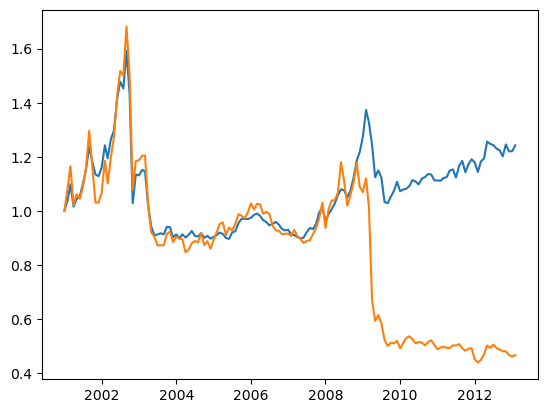

In [ ]:
try: 
    data.data_dict.pop("EJC3")
except:
    pass 

sup = data.get("SUP").copy()
mom = data.get("MOM").copy()
val = data.get("VAL").copy()

mom.fillna(0,inplace = True)
val.fillna(0,inplace = True)

fmb = res_base.params[0]
fvb = res_base.params[1]
fcb = res_base.params[2]

fmp = res_pos.params[0]
fvp = res_pos.params[1]
fcp = res_pos.params[2]

fmn = res_neg.params[0]
fvn = res_neg.params[1]
fcn = res_neg.params[2]

# basecase 
ejustc3 = fmb*mom + fvb*val + fcb

# positive
ejustc3[sup>=cuttoff] = fmp*mom[sup>=cuttoff] + fvp*val[sup>=cuttoff] + fcp

# neg

ejustc3[sup<= -cuttoff] = fmn*mom[sup<= -cuttoff] + fvn*val[sup<= -cuttoff] + fcn

data.append("EJC3",ejustc3)
port_ejc3 = data.to_port("EJC3", tmbool_train)
port_ejc3.gen_weights_from_score(0.3)
ejc_ret3, ejc_cret3= port_ejc3.get_port_ret(port_ejc3.lsw,bps=10)

# lejc_ret, lejc_cret= port_ejc.get_port_ret(port_ejc.sw,bps=10)

plt.plot(ejc_cret3)
plt.plot(ejc_cret)
# plt.plot(mom_cret)
cb.infomation_ratio(ejc_ret3,momval_ret)